In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
from sklearn.model_selection import KFold
import warnings
import time
import sys
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error
warnings.simplefilter(action='ignore', category=FutureWarning)
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows',300)
from scipy.stats import mode
from scipy import stats
import feather
import re
import warnings
import random

from IPython.display import clear_output

In [2]:
target = pd.read_csv('target2',header=None,index_col=0)

In [3]:
target = pd.read_csv('target2',header=None,index_col=0)
train = feather.read_dataframe('best_from_recent_groupped_train')
test = feather.read_dataframe('best_from_recent_groupped_test')


new_test_cols = feather.read_dataframe('new_test_columns_with_promos_fixed')

train = pd.merge(train,new_test_cols,on='card_id',how='left')
test = pd.merge(test,new_test_cols,on='card_id',how='left')


new_test_cols =  feather.read_dataframe('gropped_columns_per_month_to_last_ver2')

train = pd.merge(train,new_test_cols,on='card_id',how='left')
test = pd.merge(test,new_test_cols,on='card_id',how='left')


train_out = feather.read_dataframe('train_months_outliner_percent')
test_out = feather.read_dataframe('test_months_outliner_percent')

train = pd.merge(train,train_out,on='card_id',how='left')
test = pd.merge(test,test_out,on='card_id',how='left')

In [3]:
import pickle
with open('list_of_best_folds.pickle', 'rb') as f:
    best_cols_for_folds = pickle.load(f)

In [4]:
for x in best_cols_for_folds.keys():
    best_cols_for_folds[x][2]['learning_rate'] = 0.0005

In [6]:
warnings.filterwarnings("ignore")
folds = KFold(n_splits=5, shuffle=True, random_state=15)
oof = np.zeros(len(train))
predictions_with = np.zeros(len(test))

for fold_, (trn_idx, val_idx) in enumerate(folds.split(train.values, target.values)):
    print("fold n°{}".format(fold_))
    features,param,categorical_feats = best_cols_for_folds[fold_][1],best_cols_for_folds[fold_][2],best_cols_for_folds[fold_][3]
    
    trn_data = lgb.Dataset(train.iloc[trn_idx][features],
                           label=target.iloc[trn_idx],
                           categorical_feature=categorical_feats
                          )
    val_data = lgb.Dataset(train.iloc[val_idx][features],
                           label=target.iloc[val_idx],
                           categorical_feature=categorical_feats
                          )


    clf = lgb.train(param, 
                    trn_data,100000, 
                    valid_sets = [trn_data, val_data], 
                    verbose_eval=2500, early_stopping_rounds = 2500)

    oof[val_idx] = clf.predict(train.iloc[val_idx][features], num_iteration=clf.best_iteration)

    predictions_with += clf.predict(test[features], num_iteration=clf.best_iteration) / folds.n_splits



errr = mean_squared_error(oof, target)**0.5

print("CV score: {:<8.5f}\n".format(errr))

fold n°0
Training until validation scores don't improve for 2500 rounds.
[2500]	training's rmse: 3.57105	valid_1's rmse: 3.70769
[5000]	training's rmse: 3.45665	valid_1's rmse: 3.6751
[7500]	training's rmse: 3.38137	valid_1's rmse: 3.66517
[10000]	training's rmse: 3.32433	valid_1's rmse: 3.66126
[12500]	training's rmse: 3.27412	valid_1's rmse: 3.6597
[15000]	training's rmse: 3.22822	valid_1's rmse: 3.65936
[17500]	training's rmse: 3.18647	valid_1's rmse: 3.6595
Early stopping, best iteration is:
[15526]	training's rmse: 3.21928	valid_1's rmse: 3.65933
fold n°1
Training until validation scores don't improve for 2500 rounds.
[2500]	training's rmse: 3.58575	valid_1's rmse: 3.64075
[5000]	training's rmse: 3.47009	valid_1's rmse: 3.61284
[7500]	training's rmse: 3.3984	valid_1's rmse: 3.60539
[10000]	training's rmse: 3.34392	valid_1's rmse: 3.60277
[12500]	training's rmse: 3.29254	valid_1's rmse: 3.6014
[15000]	training's rmse: 3.24568	valid_1's rmse: 3.601
[17500]	training's rmse: 3.20201	v

In [7]:
train['target'] = target
train = train[train['target'] > -30]
target = train.pop('target')

In [8]:
for x in best_cols_for_folds.keys():
    best_cols_for_folds[x][2]['learning_rate'] = 0.0009

warnings.filterwarnings("ignore")
folds = KFold(n_splits=5, shuffle=True, random_state=15)
oof = np.zeros(len(train))
predictions_witho = np.zeros(len(test))

for fold_, (trn_idx, val_idx) in enumerate(folds.split(train.values, target.values)):
    print("fold n°{}".format(fold_))
    features,param,categorical_feats = best_cols_for_folds[fold_][1],best_cols_for_folds[fold_][2],best_cols_for_folds[fold_][3]
    
    trn_data = lgb.Dataset(train.iloc[trn_idx][features],
                           label=target.iloc[trn_idx],
                           categorical_feature=categorical_feats
                          )
    val_data = lgb.Dataset(train.iloc[val_idx][features],
                           label=target.iloc[val_idx],
                           categorical_feature=categorical_feats
                          )


    clf = lgb.train(param, 
                    trn_data,100000, 
                    valid_sets = [trn_data, val_data], 
                    verbose_eval=2500, early_stopping_rounds = 2500)

    oof[val_idx] = clf.predict(train.iloc[val_idx][features], num_iteration=clf.best_iteration)


    predictions_witho += clf.predict(test[features], num_iteration=clf.best_iteration) / folds.n_splits

    
errr = mean_squared_error(oof, target)**0.5

print("CV score: {:<8.5f}\n".format(errr))

In [10]:
target = pd.read_csv('target2',header=None,index_col=0)
train = feather.read_dataframe('best_from_recent_groupped_train')
test = feather.read_dataframe('best_from_recent_groupped_test')


new_test_cols = feather.read_dataframe('new_test_columns_with_promos_fixed')

train = pd.merge(train,new_test_cols,on='card_id',how='left')
test = pd.merge(test,new_test_cols,on='card_id',how='left')


new_test_cols =  feather.read_dataframe('gropped_columns_per_month_to_last_ver2')

train = pd.merge(train,new_test_cols,on='card_id',how='left')
test = pd.merge(test,new_test_cols,on='card_id',how='left')


train_out = feather.read_dataframe('train_months_outliner_percent')
test_out = feather.read_dataframe('test_months_outliner_percent')

train = pd.merge(train,train_out,on='card_id',how='left')
test = pd.merge(test,test_out,on='card_id',how='left')

In [11]:
target = target[1] < -30

In [12]:
for x in best_cols_for_folds.keys():
    best_cols_for_folds[x][2]['learning_rate'] = 0.001
    best_cols_for_folds[x][2]['is_unbalance'] = True

In [13]:
warnings.filterwarnings("ignore")
folds = KFold(n_splits=5, shuffle=True, random_state=15)
oof = np.zeros(len(train))
predictions_bin = np.zeros(len(test))

for fold_, (trn_idx, val_idx) in enumerate(folds.split(train.values, target.values)):
    print("fold n°{}".format(fold_))
    features,param,categorical_feats = best_cols_for_folds[fold_][1],best_cols_for_folds[fold_][2],best_cols_for_folds[fold_][3]
    
    trn_data = lgb.Dataset(train.iloc[trn_idx][features],
                           label=target.iloc[trn_idx],
                           categorical_feature=categorical_feats
                          )
    val_data = lgb.Dataset(train.iloc[val_idx][features],
                           label=target.iloc[val_idx],
                           categorical_feature=categorical_feats
                          )


    clf = lgb.train(param, 
                    trn_data,100000, 
                    valid_sets = [trn_data, val_data], 
                    verbose_eval=2500, early_stopping_rounds = 2500)

    oof[val_idx] = clf.predict(train.iloc[val_idx][features], num_iteration=clf.best_iteration)


    predictions_bin += clf.predict(test[features], num_iteration=clf.best_iteration) / folds.n_splits

    
errr = mean_squared_error(oof, target)**0.5

print("CV score: {:<8.5f}\n".format(errr))

fold n°0
Training until validation scores don't improve for 2500 rounds.
[2500]	training's rmse: 0.0979589	valid_1's rmse: 0.10104
[5000]	training's rmse: 0.0965171	valid_1's rmse: 0.100646
[7500]	training's rmse: 0.0956495	valid_1's rmse: 0.100562
[10000]	training's rmse: 0.0949802	valid_1's rmse: 0.100542
[12500]	training's rmse: 0.0945177	valid_1's rmse: 0.100537
Early stopping, best iteration is:
[11832]	training's rmse: 0.0946162	valid_1's rmse: 0.100536
fold n°1
Training until validation scores don't improve for 2500 rounds.
[2500]	training's rmse: 0.0985622	valid_1's rmse: 0.0984518
[5000]	training's rmse: 0.0970188	valid_1's rmse: 0.098093
[7500]	training's rmse: 0.0960436	valid_1's rmse: 0.0980577
[10000]	training's rmse: 0.0953476	valid_1's rmse: 0.0980651
Early stopping, best iteration is:
[7840]	training's rmse: 0.0959354	valid_1's rmse: 0.0980561
fold n°2
Training until validation scores don't improve for 2500 rounds.
[2500]	training's rmse: 0.098806	valid_1's rmse: 0.0978

In [65]:
xxx = pd.DataFrame()
xxx['card_id'] = test['card_id']
xxx['prediction_with'] = predictions_with
xxx['predictions_witho'] = predictions_witho
xxx['predictions_bin'] = predictions_bin

In [66]:
xxx = xxx.sort_values(ascending=False,by='predictions_bin').reset_index(drop=True)
xxx.to_feather('columns_of_best_results24')

In [67]:
test_target = xxx[['card_id','prediction_with']]
test_target.columns = ['card_id','target']
test_target.to_csv('test_pred25feb.csv',index=False)

In [ ]:
#-33.2219

In [68]:
xxx = pd.merge(xxx,test_out,on='card_id',how='left')

In [69]:
test = pd.read_csv('C:\\kdata\\test.csv')

In [70]:
test['first_active_month_coded'] = test['first_active_month'].astype(np.datetime64)
test['first_active_month_coded'] = ((test['first_active_month_coded'].dt.year-2011)*12+test['first_active_month_coded'].dt.month).fillna(83).astype(np.int16)
xxx = pd.merge(xxx,test[['card_id','first_active_month_coded']],on='card_id',how='left')

In [71]:
groupped_by_month = xxx.groupby(['first_active_month_coded','card_id']).agg({'predictions_bin':'max','first_active_month_coded':'max','outliners_months_percent':'max'})

In [72]:
groupped_by_month.outliners_months_percent.fillna(0,inplace=True)

In [73]:
xxx.outliners_months_percent.fillna(0,inplace=True)

In [83]:
outs_array = []
for x in range(11,86):
    if x==24:
        aprox = 0.03
    elif x==30:
        aprox = 0.015
    else:
        aprox = xxx[xxx.first_active_month_coded==x].outliners_months_percent.mean()
    length_vec = groupped_by_month.loc[x].count().mean()
    num_of_outs = int(length_vec*aprox)
    num_of_non_outs = int(length_vec - length_vec*aprox)
    out_vec_length = len([1] * num_of_outs + [0]*num_of_non_outs)
    if out_vec_length < length_vec:
        num_of_non_outs += 1
        out_vec_length = len([1] * num_of_outs + [0]*num_of_non_outs)
    outs_array += [0]*num_of_non_outs + [1] * num_of_outs

In [84]:
groupped_by_month.sort_values(['first_active_month_coded','predictions_bin'],inplace=True)

In [86]:
groupped_by_month['approx_place_of_outliner'] = outs_array

In [87]:
groupped_by_month.columns = ['predictions_bin', 'first_active_month_coded_drop','outliners_months_percent', 'approx_place_of_outliner']

In [89]:
del groupped_by_month['first_active_month_coded_drop']

In [90]:
groupped_by_month.reset_index(inplace=True)

In [91]:
xxx = pd.merge(xxx,groupped_by_month[['card_id','approx_place_of_outliner']])

In [92]:
xxx.sort_values(by='predictions_bin',ascending=False,inplace=True)

In [93]:
xxx.reset_index(drop=True,inplace=True)

In [96]:
xxx['target'] = (((xxx.index < 60000) & (xxx.approx_place_of_outliner != 1)) * xxx.prediction_with) +\
                (xxx.approx_place_of_outliner == 1) * -33.2219 +\
                (xxx.index >= 60000) * xxx.predictions_witho

In [118]:
xxx['target_combo'] = ((xxx.index <= 18000) * xxx.prediction_with) + (xxx.index >= 50000) * xxx.predictions_witho

In [119]:
xxx['target_combo'] += ((xxx.index > 18000) & (xxx.index < 50000)) * ((50000-xxx.index.values)/32000)*xxx.prediction_with +\
                      ((xxx.index > 18000) & (xxx.index < 50000)) * (1-((50000-xxx.index.values)/32000))*xxx.predictions_witho

In [121]:
xxx.iloc[17990:18100,:]

,card_id,prediction_with,predictions_witho,predictions_bin,outliners_months_percent,first_active_month_coded,approx_place_of_outliner,target,target_combo
17990,C_ID_d72b552e6f,0.133222,0.399262,0.015181,0.012372,65,0,0.133222,0.133222
17991,C_ID_4005803053,0.019947,0.790414,0.015181,0.017756,74,0,0.019947,0.019947
17992,C_ID_04567afcc2,-1.191193,-0.416898,0.015180,0.013462,68,0,-1.191193,-1.191193
17993,C_ID_06bdb941b9,-1.598453,-0.858892,0.015180,0.010373,78,0,-1.598453,-1.598453
17994,C_ID_dd1946615f,0.868539,2.243171,0.015179,0.013811,76,0,0.868539,0.868539
17995,C_ID_1d6342ad78,0.824401,1.282017,0.015179,0.016927,75,0,0.824401,0.824401
17996,C_ID_649dd072c4,-0.223409,0.349661,0.015178,0.016927,75,0,-0.223409,-0.223409
17997,C_ID_931ffd5dd4,0.663914,0.875036,0.015178,0.016927,75,0,0.663914,0.663914
17998,C_ID_8e2b81475f,-1.103186,-0.476295,0.015175,0.013462,68,0,-1.103186,-1.103186
17999,C_ID_8e813a6fee,-2.189146,-1.437506,0.015172,0.013592,70,0,-2.189146,-2.189146


In [122]:
xxx[['card_id','target_combo']].to_csv('test_pred_combo25feb_targ_mod.csv',index=False)

In [ ]:
# BEST TRY WITHOUT FOLD STACKING

In [4]:
import pickle
with open('list_of_best_folds.pickle', 'rb') as f:
    best_cols_for_folds = pickle.load(f)

In [5]:
for x in best_cols_for_folds.keys():
    best_cols_for_folds[x][2]['learning_rate'] = 0.0005

In [7]:
features,param,categorical_feats = best_cols_for_folds[1][1],best_cols_for_folds[1][2],best_cols_for_folds[1][3]

warnings.filterwarnings("ignore")
folds = KFold(n_splits=5, shuffle=True, random_state=15)
oof = np.zeros(len(train))
predictions_with_the_best = np.zeros(len(test))

for fold_, (trn_idx, val_idx) in enumerate(folds.split(train.values, target.values)):
    print("fold n°{}".format(fold_))
    
    
    trn_data = lgb.Dataset(train.iloc[trn_idx][features],
                           label=target.iloc[trn_idx],
                           categorical_feature=categorical_feats
                          )
    val_data = lgb.Dataset(train.iloc[val_idx][features],
                           label=target.iloc[val_idx],
                           categorical_feature=categorical_feats
                          )


    clf = lgb.train(param, 
                    trn_data,100000, 
                    valid_sets = [trn_data, val_data], 
                    verbose_eval=2500, early_stopping_rounds = 2500)

    oof[val_idx] = clf.predict(train.iloc[val_idx][features], num_iteration=clf.best_iteration)

    predictions_with_the_best += clf.predict(test[features], num_iteration=clf.best_iteration) / folds.n_splits



errr = mean_squared_error(oof, target)**0.5

print("CV score: {:<8.5f}\n".format(errr))

fold n°0
Training until validation scores don't improve for 2500 rounds.
[2500]	training's rmse: 3.56937	valid_1's rmse: 3.7077
[5000]	training's rmse: 3.45383	valid_1's rmse: 3.6751
[7500]	training's rmse: 3.37976	valid_1's rmse: 3.665
[10000]	training's rmse: 3.32382	valid_1's rmse: 3.66089
[12500]	training's rmse: 3.27457	valid_1's rmse: 3.65924
[15000]	training's rmse: 3.22757	valid_1's rmse: 3.65883
[17500]	training's rmse: 3.18331	valid_1's rmse: 3.65879
Early stopping, best iteration is:
[16242]	training's rmse: 3.20547	valid_1's rmse: 3.65871
fold n°1
Training until validation scores don't improve for 2500 rounds.
[2500]	training's rmse: 3.58575	valid_1's rmse: 3.64075
[5000]	training's rmse: 3.47009	valid_1's rmse: 3.61284
[7500]	training's rmse: 3.3984	valid_1's rmse: 3.60539
[10000]	training's rmse: 3.34392	valid_1's rmse: 3.60277
[12500]	training's rmse: 3.29254	valid_1's rmse: 3.6014
[15000]	training's rmse: 3.24568	valid_1's rmse: 3.601
[17500]	training's rmse: 3.20201	va

In [8]:
train['target'] = target
train = train[train['target'] > -30]
target = train.pop('target')

In [9]:
for x in best_cols_for_folds.keys():
    best_cols_for_folds[x][2]['learning_rate'] = 0.0009

features,param,categorical_feats = best_cols_for_folds[1][1],best_cols_for_folds[1][2],best_cols_for_folds[1][3]    
    
warnings.filterwarnings("ignore")
folds = KFold(n_splits=5, shuffle=True, random_state=15)
oof = np.zeros(len(train))
predictions_witho_the_best = np.zeros(len(test))

for fold_, (trn_idx, val_idx) in enumerate(folds.split(train.values, target.values)):
    print("fold n°{}".format(fold_))
    
    trn_data = lgb.Dataset(train.iloc[trn_idx][features],
                           label=target.iloc[trn_idx],
                           categorical_feature=categorical_feats
                          )
    val_data = lgb.Dataset(train.iloc[val_idx][features],
                           label=target.iloc[val_idx],
                           categorical_feature=categorical_feats
                          )


    clf = lgb.train(param, 
                    trn_data,100000, 
                    valid_sets = [trn_data, val_data], 
                    verbose_eval=2500, early_stopping_rounds = 2500)

    oof[val_idx] = clf.predict(train.iloc[val_idx][features], num_iteration=clf.best_iteration)


    predictions_witho_the_best += clf.predict(test[features], num_iteration=clf.best_iteration) / folds.n_splits

    
errr = mean_squared_error(oof, target)**0.5

print("CV score: {:<8.5f}\n".format(errr))

fold n°0
Training until validation scores don't improve for 2500 rounds.
[2500]	training's rmse: 1.536	valid_1's rmse: 1.57622
[5000]	training's rmse: 1.49597	valid_1's rmse: 1.56409
[7500]	training's rmse: 1.46854	valid_1's rmse: 1.56096
[10000]	training's rmse: 1.44375	valid_1's rmse: 1.55983
[12500]	training's rmse: 1.42077	valid_1's rmse: 1.5594
[15000]	training's rmse: 1.39914	valid_1's rmse: 1.55931
[17500]	training's rmse: 1.37861	valid_1's rmse: 1.55935
Early stopping, best iteration is:
[16016]	training's rmse: 1.39064	valid_1's rmse: 1.55927
fold n°1
Training until validation scores don't improve for 2500 rounds.
[2500]	training's rmse: 1.53658	valid_1's rmse: 1.57269
[5000]	training's rmse: 1.49627	valid_1's rmse: 1.56061
[7500]	training's rmse: 1.46815	valid_1's rmse: 1.5575
[10000]	training's rmse: 1.44336	valid_1's rmse: 1.5565
[12500]	training's rmse: 1.42093	valid_1's rmse: 1.55608
[15000]	training's rmse: 1.39949	valid_1's rmse: 1.55596
Early stopping, best iteration i

In [10]:
zzz = pd.DataFrame()
zzz['card_id'] = test['card_id']
zzz['predictions_with_the_best'] = predictions_with_the_best
zzz['predictions_witho_the_best'] = predictions_witho_the_best

In [13]:
zzz.to_feather('best_fold_result26last')

In [14]:
zzz

,card_id,predictions_with_the_best,predictions_witho_the_best
0,C_ID_0ab67a22ab,-1.665299,-0.424932
1,C_ID_130fd0cbdd,-0.557327,-0.281198
2,C_ID_b709037bc5,-1.251742,-0.910755
3,C_ID_d27d835a9f,-0.007883,0.007137
4,C_ID_2b5e3df5c2,-1.253438,-1.098061
5,C_ID_5814b4f13c,0.265095,0.497403
6,C_ID_a1b3c75277,0.020565,0.164331
7,C_ID_f7cada36d3,0.724261,0.923701
8,C_ID_9d2bc8dfc4,-0.777398,-0.269152
9,C_ID_6d8dba8475,-0.817822,-0.264918


In [11]:
xxx = feather.read_dataframe('columns_of_best_results24')

In [12]:
xxx = pd.merge(xxx,zzz,on='card_id',how='left')

In [16]:
xxx.to_feather('all_best_submits_last')

In [2]:
zzz = feather.read_dataframe('all_best_submits_last')

In [23]:
zzz[['card_id','predictions_with_the_best']].rename({'predictions_with_the_best':'target'},axis=1).to_csv('best_sub26.csv',index=False)

In [3]:
zzz.head()

,card_id,prediction_with,predictions_witho,predictions_bin,predictions_with_the_best,predictions_witho_the_best
0,C_ID_877b879853,-16.549977,0.206198,0.391665,-16.917525,0.195542
1,C_ID_ac114ef831,-16.701803,-0.162176,0.379878,-16.738964,-0.179681
2,C_ID_a7d1cd6b7c,-14.838910,0.677826,0.370574,-14.591760,0.704387
3,C_ID_be92f84f5c,-16.809613,0.245454,0.367967,-16.604844,0.243550
4,C_ID_767923bdb9,-13.692219,0.295697,0.365895,-13.976588,0.294055


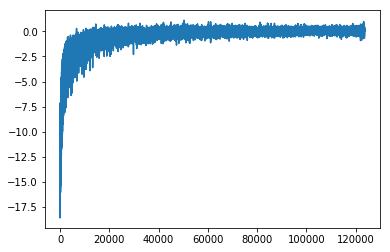

In [14]:
(zzz.predictions_with_the_best - zzz.predictions_witho_the_best).plot()

In [17]:
zzz['target'] = ((zzz.index <= 18000) * zzz.predictions_with_the_best) + (zzz.index >= 60000) * zzz.predictions_witho_the_best

zzz['target'] = ((zzz.index > 18000) & (zzz.index < 60000)) * ((60000-zzz.index.values)/42000)*zzz.predictions_with_the_best +\
                      ((zzz.index > 18000) & (zzz.index < 60000)) * (1-((60000-zzz.index.values)/42000))*zzz.predictions_witho_the_best

In [18]:
zzz[['card_id','target']].to_csv('best_sub_combind_26.csv',index=False)

In [ ]:
xxx['target_combo'] += ((xxx.index > 18000) & (xxx.index < 50000)) * ((50000-xxx.index.values)/32000)*xxx.prediction_with +\
                      ((xxx.index > 18000) & (xxx.index < 50000)) * (1-((50000-xxx.index.values)/32000))*xxx.predictions_witho